## Stacking_regressor

## import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
import datetime
import sklearn
import gc
import joblib
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm

In [2]:
import pandas as pd
train_df=pd.read_csv('train_preprocessed1.csv')

In [3]:
train_df=train_df.drop(['Unnamed: 0'], axis=1)

In [4]:
train_df.head()

,building_id,meter,meter_reading,dayofweek_x,group_x,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,relative_humidity,feels_like,is_holiday
0,105,0,3.191,4,1,1,0,10.836,3.8,0.0,2.4,0.0,1021.0,240.0,3.1,90.56,36.94,1
1,106,3,0.000,4,1,1,0,8.586,3.8,0.0,2.4,0.0,1021.0,240.0,3.1,90.56,36.94,1
2,108,0,4.523,4,1,1,0,11.310,3.8,0.0,2.4,0.0,1021.0,240.0,3.1,90.56,36.94,1
3,109,0,4.406,4,1,1,0,10.950,3.8,0.0,2.4,0.0,1021.0,240.0,3.1,90.56,36.94,1
4,109,3,0.000,4,1,1,0,10.950,3.8,0.0,2.4,0.0,1021.0,240.0,3.1,90.56,36.94,1


## Feature Selection

### LOFO Importance (Leave One Feature Out)

* LOFO (Leave One Feature Out) Importance calculates the importances of a set of features based on a metric of choice, for a 

model of choice, by iteratively removing each feature from the set, and evaluating the performance of the model, with a 

validation scheme of choice, based on the chosen metric.


* LOFO first evaluates the performance of the model with all the input features included, then iteratively removes one feature 

at a time, retrains the model, and evaluates its performance on a validation set. The mean and standard deviation (across the 

folds) of the importance of each feature is then reported


In [9]:
# pip install lofo-importance

In [16]:
import lightgbm as lgb
cat_cols = ['building_id', 'meter', 'site_id', 'primary_use','dayofweek_x','is_holiday','group_x']

model = lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=500,objective='regression',n_jobs=-1)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


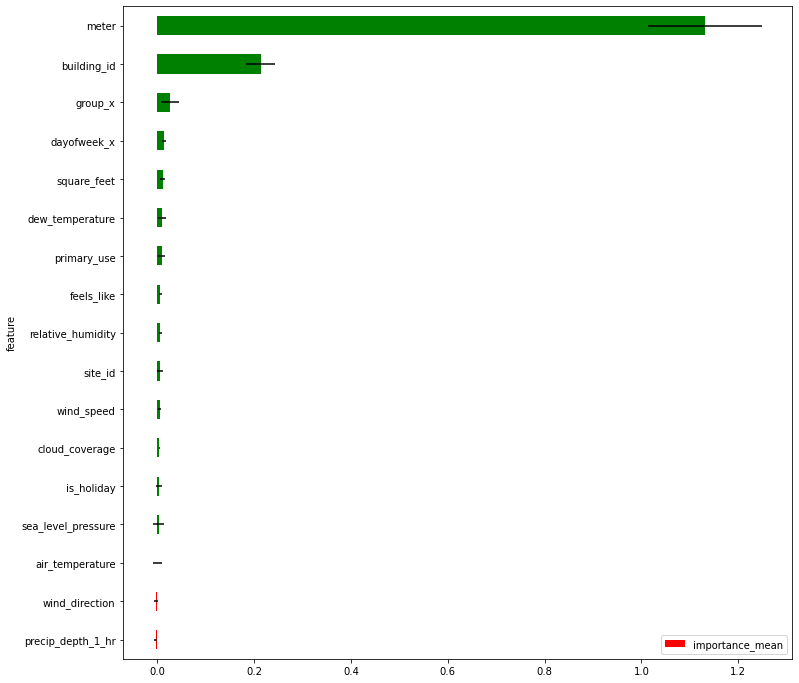

In [17]:
from sklearn.model_selection import KFold

from lofo import LOFOImportance, Dataset, plot_importance

cv = KFold(n_splits=3, shuffle=False, random_state=0)

features = ['square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
               'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed','relative_humidity','feels_like'] + cat_cols

dataset = Dataset(df=train_df, target="meter_reading", features=features)

lofo_imp = LOFOImportance(dataset, model=model, cv=cv, scoring="mean_squared_error", fit_params={"categorical_feature": cat_cols})

importance_df = lofo_imp.get_importance()

plot_importance(importance_df, figsize=(12, 12))

#### precip_depth_1_hr and wind direction have negative impact on model 

#### air temp and sea level pressure has minimul impact

#### So droping those features from data

In [5]:
train_df=train_df.drop(['precip_depth_1_hr','wind_direction','air_temperature','sea_level_pressure'], axis=1)

In [14]:
test_df=pd.read_csv('test_preprocessed1.csv')
test_df=test_df.drop(['Unnamed: 0','year_built','row_id'], axis=1) 
test_df.head()

,building_id,meter,dayofweek_x,group_x,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,relative_humidity,feels_like,is_holiday
0,0,0,6,1,0,0,8.913685,17.8,4.0,11.7,0.2827,1021.5,100.0,3.6,67.5,64.06,1
1,1,0,6,1,0,0,7.908755,17.8,4.0,11.7,0.2827,1021.5,100.0,3.6,67.5,64.06,1
2,2,0,6,1,0,0,8.589886,17.8,4.0,11.7,0.2827,1021.5,100.0,3.6,67.5,64.06,1
3,3,0,6,1,0,0,10.072639,17.8,4.0,11.7,0.2827,1021.5,100.0,3.6,67.5,64.06,1
4,4,0,6,1,0,0,11.666573,17.8,4.0,11.7,0.2827,1021.5,100.0,3.6,67.5,64.06,1


In [16]:
test_df=test_df.drop(['precip_depth_1_hr','wind_direction','air_temperature','sea_level_pressure'], axis=1)

In [6]:
df1 = train_df[train_df['group_x'] != 3]
df2 = train_df[train_df['group_x'] == 3]
del train_df

In [7]:
y_df2=df2['meter_reading']
x_df2=df2.drop(['meter_reading'], axis=1)
del df2

## Base_regressors[60 LGB_Regressors ]

In [17]:
import lightgbm as lgb
df2_pred=[]
test_pred=[]
for i in tqdm(range(0,60)):

    df=df1.sample(n=200000,replace = True) 
    
    y_train_sam=df['meter_reading']
    train_sam=df.drop(['meter_reading'], axis=1)
    
    regressor=lgb.LGBMRegressor(boosting_type='gbdt',n_estimators=200,max_depth=50,objective='regression',n_jobs=-1)

    regressor.fit(train_sam,y_train_sam)
    
    predict_df2 =  regressor.predict(x_df2)
    predict_test =  regressor.predict(test_df)
    k=sqrt(mean_squared_error(y_df2, predict_df2))
    print(k)

   
    df2_pred.append(predict_df2)
    test_pred.append(predict_test)
   
    
    del train_sam,regressor, k ,df,y_train_sam,predict_df2


  2%|▏         | 1/60 [03:05<3:02:49, 185.93s/it]

1.082110482160525


  3%|▎         | 2/60 [06:13<3:00:19, 186.54s/it]

1.0775931362679971


  5%|▌         | 3/60 [09:27<2:59:11, 188.61s/it]

1.0758485394910884


  7%|▋         | 4/60 [12:34<2:55:39, 188.21s/it]

1.0842109005506528


  8%|▊         | 5/60 [15:43<2:52:47, 188.49s/it]

1.090753855051707


 10%|█         | 6/60 [18:48<2:48:36, 187.34s/it]

1.0886789025023214


 12%|█▏        | 7/60 [21:53<2:44:50, 186.61s/it]

1.086483197648523


 13%|█▎        | 8/60 [24:58<2:41:20, 186.16s/it]

1.0777591569344744


 15%|█▌        | 9/60 [28:00<2:37:05, 184.81s/it]

1.0739788528291296


 17%|█▋        | 10/60 [30:58<2:32:30, 183.01s/it]

1.088085895662676


 18%|█▊        | 11/60 [34:08<2:31:01, 184.94s/it]

1.0816250956299605


 20%|██        | 12/60 [37:10<2:27:22, 184.22s/it]

1.075817492672595


 22%|██▏       | 13/60 [40:12<2:23:40, 183.42s/it]

1.072882918016894


 23%|██▎       | 14/60 [43:15<2:20:33, 183.34s/it]

1.0788209480963842


 25%|██▌       | 15/60 [46:15<2:16:46, 182.36s/it]

1.0769044793521325


 27%|██▋       | 16/60 [49:21<2:14:26, 183.32s/it]

1.0796410706688824


 28%|██▊       | 17/60 [52:27<2:12:01, 184.21s/it]

1.0820305427807815


 30%|███       | 18/60 [55:28<2:08:15, 183.22s/it]

1.0849579415794997


 32%|███▏      | 19/60 [58:32<2:05:19, 183.41s/it]

1.082583227712422


 33%|███▎      | 20/60 [1:01:40<2:03:10, 184.75s/it]

1.086168027903634


 35%|███▌      | 21/60 [1:04:49<2:01:01, 186.19s/it]

1.080559892943969


 37%|███▋      | 22/60 [1:07:51<1:57:01, 184.78s/it]

1.0775156835227127


 38%|███▊      | 23/60 [1:10:56<1:54:04, 184.98s/it]

1.0783102537153475


 40%|████      | 24/60 [1:13:55<1:49:52, 183.11s/it]

1.0833198474368952


 42%|████▏     | 25/60 [1:17:06<1:48:14, 185.55s/it]

1.0813420978819968


 43%|████▎     | 26/60 [1:20:10<1:44:50, 185.00s/it]

1.0829807436382344


 45%|████▌     | 27/60 [1:23:16<1:41:56, 185.35s/it]

1.08255902001532


 47%|████▋     | 28/60 [1:26:23<1:39:07, 185.87s/it]

1.078601649853818


 48%|████▊     | 29/60 [1:29:25<1:35:22, 184.59s/it]

1.0813352857366654


 50%|█████     | 30/60 [1:32:30<1:32:19, 184.66s/it]

1.0768938346890062


 52%|█████▏    | 31/60 [1:35:34<1:29:13, 184.59s/it]

1.0827876107645769


 53%|█████▎    | 32/60 [1:38:37<1:25:58, 184.22s/it]

1.0796321724000395


 55%|█████▌    | 33/60 [1:41:40<1:22:40, 183.72s/it]

1.0790277540274238


 57%|█████▋    | 34/60 [1:44:44<1:19:37, 183.77s/it]

1.0824499806880155


 58%|█████▊    | 35/60 [1:47:50<1:16:54, 184.56s/it]

1.0838185291025617


 60%|██████    | 36/60 [1:50:51<1:13:23, 183.47s/it]

1.0865770041616298


 62%|██████▏   | 37/60 [1:54:02<1:11:11, 185.70s/it]

1.082204306285378


 63%|██████▎   | 38/60 [1:57:02<1:07:25, 183.89s/it]

1.0767027679071655


 65%|██████▌   | 39/60 [2:00:06<1:04:25, 184.08s/it]

1.0767231027039394


 67%|██████▋   | 40/60 [2:03:09<1:01:14, 183.70s/it]

1.0797291707558159


 68%|██████▊   | 41/60 [2:06:09<57:49, 182.60s/it]  

1.0845522571067834


 70%|███████   | 42/60 [2:09:11<54:45, 182.54s/it]

1.0805361606567985


 72%|███████▏  | 43/60 [2:12:19<52:10, 184.14s/it]

1.0878447590871545


 73%|███████▎  | 44/60 [2:15:19<48:42, 182.66s/it]

1.0833115123934463


 75%|███████▌  | 45/60 [2:18:19<45:29, 181.99s/it]

1.086850572655314


 77%|███████▋  | 46/60 [2:21:28<42:55, 183.96s/it]

1.0827288304898894


 78%|███████▊  | 47/60 [2:24:26<39:28, 182.20s/it]

1.0840872645987791


 80%|████████  | 48/60 [2:27:23<36:07, 180.66s/it]

1.0840755436762926


 82%|████████▏ | 49/60 [2:30:25<33:11, 181.05s/it]

1.082294415635014


 83%|████████▎ | 50/60 [2:33:29<30:20, 182.02s/it]

1.0803725335879357


 85%|████████▌ | 51/60 [2:36:33<27:22, 182.51s/it]

1.0780211717493633


 87%|████████▋ | 52/60 [2:39:37<24:24, 183.01s/it]

1.07705358969948


 88%|████████▊ | 53/60 [2:42:40<21:20, 182.99s/it]

1.0764223333646539


 90%|█████████ | 54/60 [2:45:45<18:22, 183.69s/it]

1.0823242912139746


 92%|█████████▏| 55/60 [2:48:48<15:17, 183.46s/it]

1.0883183851907223


 93%|█████████▎| 56/60 [2:51:45<12:06, 181.68s/it]

1.0829753983830075


 95%|█████████▌| 57/60 [2:54:52<09:09, 183.27s/it]

1.076981351683782


 97%|█████████▋| 58/60 [2:57:58<06:07, 183.90s/it]

1.080659882878574


 98%|█████████▊| 59/60 [3:01:04<03:04, 184.59s/it]

1.075358090178551


100%|██████████| 60/60 [3:04:08<00:00, 184.15s/it]

1.0821892025859823


#### saving predicted values to pickle file

In [18]:
joblib.dump(df2_pred, 'df2_pred_60lgb.pkl') 
joblib.dump(y_df2, 'y_df2.pkl') 
joblib.dump(test_pred, 'test_pred_60lgb.pkl') 

['test_pred_60lgb.pkl']

## MetaRegressor (LGB_regresor)

In [2]:
df2_pred = joblib.load('df2_pred_60lgb.pkl')
y_df2 =joblib.load('y_df2.pkl')

In [3]:
df2_pre = np.array(df2_pred)
df2_pre  = np.transpose(df2_pre)
df2_pre.shape

(6701033, 60)

In [4]:
y_df2.shape

(6701033,)

### Training

In [5]:
import lightgbm as lgb

regressor_meta=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=350,max_depth=50,objective='regression',n_jobs=-1)

regressor_meta.fit(df2_pre,y_df2)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=50,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=350, n_jobs=-1, num_leaves=500,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [6]:
test_pred =joblib.load('test_pred_60lgb.pkl')

In [7]:
test_pred = np.array(test_pred)

In [8]:
test_pre  = np.transpose(test_pred)
test_pre.shape

(41697600, 60)

In [9]:
predict_y =  regressor_meta.predict(test_pre)
joblib.dump(predict_y, 'submission.pkl') 

['submission.pkl']

In [2]:
predict_y =joblib.load('submission.pkl')


In [3]:
pred = np.expm1(predict_y)

In [6]:
submission_with_featureselection.head()

,row_id,meter_reading
0,0,156.391388
1,1,69.274513
2,2,9.237787
3,3,255.232712
4,4,1256.400513


In [4]:
df_test = pd.read_csv('data/test.csv')
row_ids = df_test["row_id"]

In [5]:
submission_with_featureselection = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission_with_featureselection['meter_reading'] = submission_with_featureselection['meter_reading'].astype('float32')
submission_with_featureselection['row_id'] = submission_with_featureselection['row_id'].astype('int32')

In [7]:
submission_with_featureselection.to_csv('submission_with_featureselection2.csv',index=False)

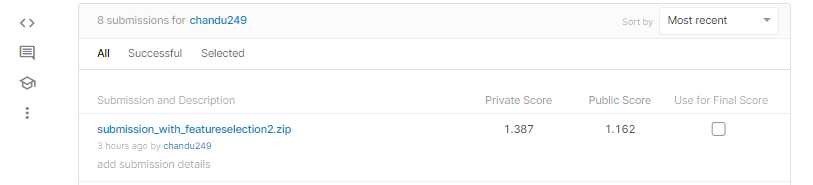

In [5]:
from IPython.display import Image
Image(filename='stack_with-fs.PNG', width=500, height=3500)

## Summery of notebook

 1) Divided Train Data into 2 parts (df1) and (df2)
              
 2) Used df1 for base learners training then using these base learners predicted df2 readings (df2_pred) and test readings (test_pred)
 
 3) Then used df2_pred and y_df2 to train the meta regressor
 
 4) Then predicted the Final test labels from (test_pred)
       
       
      